<a href="https://colab.research.google.com/github/AbhishekSubramanian/Enhancing-Emotional-Well-Being-through-ML-based-MER/blob/main/Emotion_Recognition_in_Music_CNN_ECE5424.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa numpy pandas matplotlib

## Defining File Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# # Navigate to your dataset folder
# !ls '/content/drive/My Drive/VTFall24/aml-project/audio-files'

Mounted at /content/drive


In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
# Path to audio files
audio_folder = '/content/drive/My Drive/VTFall24/aml-project/audio-files'

# Load annotations
annotations_path = '/content/drive/My Drive/VTFall24/aml-project/static_annotations.csv'
annotations = pd.read_csv(annotations_path)

# Inspect annotations
print(annotations.head())


   song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69


## MFCC Feature Extraction Function

In [ ]:
def extract_mfcc_single_feature(audio_path, n_mfcc=13, max_timesteps=92):
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        print(f"Original MFCC shape: {mfccs.shape}")  # Should print (13, timesteps)

        # Pad or truncate to max_timesteps
        if mfccs.shape[1] < max_timesteps:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_timesteps - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_timesteps]

        print(f"MFCC after padding/truncating: {mfccs.shape}")  # Should print (13, 92)

        # Reduce 13 features to 1 by averaging
        single_feature = np.mean(mfccs, axis=0)
        print(f"Shape after averaging: {single_feature.shape}")  # Should print (92,)

        return single_feature.reshape(-1, 1)  # Shape: (92, 1)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


## Extracting features using the defined function

In [ ]:
# Extract features for the training dataset
data = []
for _, row in annotations.iterrows():
    audio_path = os.path.join(audio_folder, f"{int(row['song_id'])}.mp3")
    mfcc_features = extract_mfcc_single_feature(audio_path, n_mfcc=13, max_timesteps=92)
    if mfcc_features is not None:
        print(f"MFCC shape for {row['song_id']}: {mfcc_features.shape}")
        data.append((mfcc_features, row[' valence_mean'], row[' arousal_mean']))

# Convert to DataFrame
df = pd.DataFrame(data, columns=['features', 'valence_mean', 'arousal_mean'])

# Prepare features and labels
X_train = np.array([np.array(f) for f in df['features']])  # Shape: (samples, 92, 1)
y_train = df[['valence_mean', 'arousal_mean']].values

# Normalize features
X_train = (X_train - np.mean(X_train, axis=0)) / (np.std(X_train, axis=0) + 1e-8)



In [ ]:
print(X_train.shape)

(1744, 92, 1)


## Saving the features

In [ ]:
# print(df['features'][10])
np.save('features.npy', X_train)
np.save('labels.npy', y_train)

## Splitting the Dataset

In [ ]:
# from sklearn.model_selection import train_test_split

# # Split into train and temp sets (80% train, 20% temp)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# # Split temp into validation and test sets (50% of temp each → 10% each of original data)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Print shapes
# print(f"Train set: {X_train.shape}, {y_train.shape}")
# print(f"Validation set: {X_val.shape}, {y_val.shape}")
# print(f"Test set: {X_test.shape}, {y_test.shape}")


Train set: (1116, 92, 1), (1116, 2)
Validation set: (139, 92, 1), (139, 2)
Test set: (140, 92, 1), (140, 2)


## Split into training and validation sets (80/20 split)

In [ ]:
# Split into training and validation sets (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Defining the CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError


# Define CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(92, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='linear')  # Output layer for regression
])


model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])  # Use Mean Squared Error for regression
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 90, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │         368,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,282 (1.41 MB)

 Trainable params: 369,282 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Reshape X for Conv1D (requires 3D input)
X_train = X_train
X_val = X_val

##65%
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=5, verbose=1
# )

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
# )

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=60,  # Allow more epochs, early stopping will prevent unnecessary training
#     batch_size=32,
#     callbacks=[lr_scheduler, early_stopping]
# )


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.8790 - mean_absolute_error: 2.6148 - val_loss: 1.9490 - val_mean_absolute_error: 1.1107
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4198 - mean_absolute_error: 1.2217 - val_loss: 1.1116 - val_mean_absolute_error: 0.8325
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8785 - mean_absolute_error: 1.0988 - val_loss: 1.0265 - val_mean_absolute_error: 0.8106
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7987 - mean_absolute_error: 1.0621 - val_loss: 1.0498 - val_mean_absolute_error: 0.8277
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8593 - mean_absolute_error: 1.0900 - val_loss: 1.0643 - val_mean_absolute_error: 0.8313
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7770 - mean_absolute_error: 1.0523 - val_loss: 1.0220 - val_mean_absolute_error: 0.8166
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7387 - mean_absolute_error: 1.0569 - val_loss

In [ ]:
print(f"Shape of X_train: {X_train.shape}")  # Should print (samples, 92, 13)
print(f"Shape of X_val: {X_val.shape}")      # Should print (samples, 92, 13)

Shape of X_train: (1395, 92, 1)
Shape of X_val: (349, 92, 1)


## Saving the trained model

In [ ]:
model.save('/content/drive/My Drive/VTFall24/aml-project/cnn_DEFAULT_model.h5')

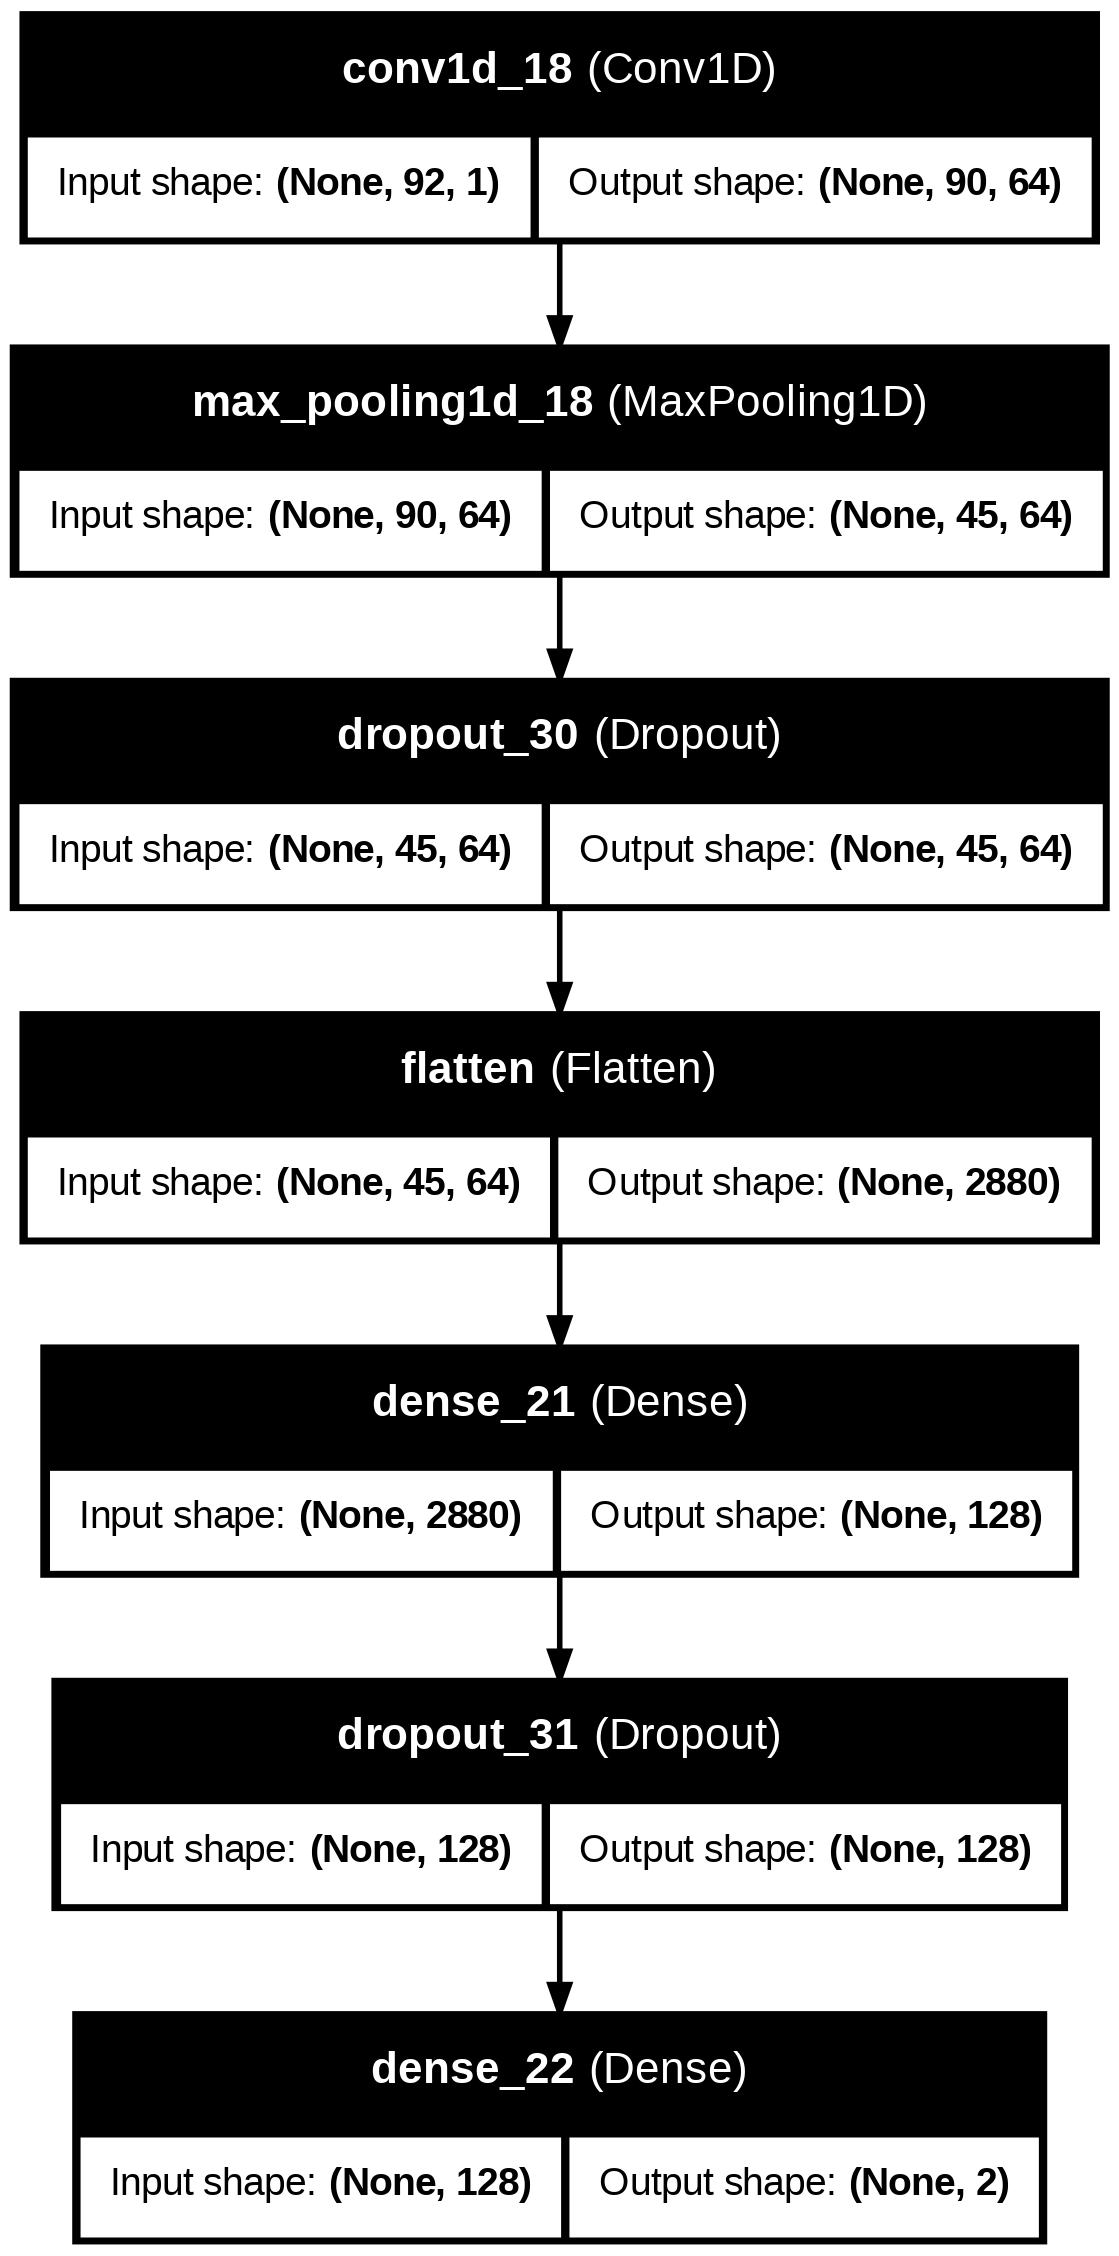

In [ ]:
from tensorflow.keras.utils import plot_model

# Load the CNN model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/VTFall24/aml-project/cnn_DEFAULT_model.h5')

# Save the architecture diagram
plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True)

## Paths to new dataset files

In [ ]:
annotations_file = "/content/drive/My Drive/VTFall24/aml-project/test_static_annotations.csv"
features_file = "/content/drive/My Drive/VTFall24/aml-project/test_audio_features.csv"
model_path = '/content/drive/My Drive/VTFall24/aml-project/cnn_DEFAULT_model.h5'

## Load the test annotations

In [ ]:
# Load annotations and features for the new dataset
annotations_df = pd.read_csv(annotations_file)
features_df = pd.read_csv(features_file)
# Rename columns for consistency
annotations_df.rename(columns={'mean_arousal': 'arousal_mean', 'mean_valence': 'valence_mean'}, inplace=True)
# Merge the datasets using 'song_id'
merged_df = pd.merge(annotations_df, features_df, on="song_id", how="inner")

In [ ]:
print(merged_df.columns)

Index(['song_id', 'arousal_mean', 'std_arousal', 'valence_mean', 'std_valence',
       'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3',
       'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7',
       'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11',
       'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15',
       'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 'mfcc_mean_19',
       'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4',
       'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9',
       'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13',
       'mfcc_std_14', 'mfcc_std_15', 'mfcc_std_16', 'mfcc_std_17',
       'mfcc_std_18', 'mfcc_std_19', 'chroma_mean_0', 'chroma_mean_1',
       'chroma_mean_2', 'chroma_mean_3', 'chroma_mean_4', 'chroma_mean_5',
       'chroma_mean_6', 'chroma_mean_7', 'chroma_mean_8', 'chroma_mean_9',
       'chroma_mean_10', 'chroma_mean_11', 'chroma_std_0', 'chroma

In [ ]:
# Separate features and labels
feature_columns = [col for col in merged_df.columns if col not in ['song_id', 'valence_mean', 'arousal_mean']]
X_test = merged_df[feature_columns].values
y_test = merged_df[['valence_mean', 'arousal_mean']].values

# Normalize features
X_test = (X_test - np.mean(X_test, axis=0)) / (np.std(X_test, axis=0) + 1e-8)

# Reshape features for Conv1D
X_test = X_test[..., np.newaxis]

In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (1395, 92, 1)
Shape of X_test: (744, 92, 1)


In [ ]:
# Load the trained CNN model
from tensorflow.keras.models import load_model
import numpy as np

model = load_model(model_path)

# Evaluate the model on the new test dataset
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Generate predictions with progress messages
print("Processing predictions...")
y_pred = model.predict(X_test)

# Add progress print statements
for i in range(len(X_test)):
    print(f"Processed {i + 1}/{len(X_test)} samples (Song ID: {i + 1})")

# Calculate prediction accuracy (customized for regression)
accuracy = 100 - np.mean(np.abs(y_pred - y_test) / np.maximum(np.abs(y_test), 1e-8)) * 100
print(f"Prediction Accuracy: {accuracy:.2f}%")


## PLotting Metrics for Evaluation

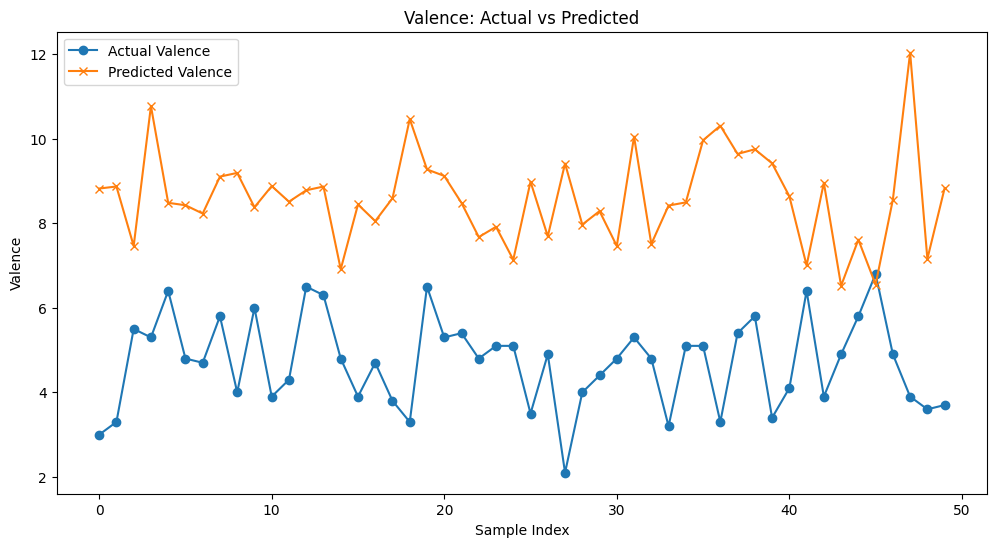

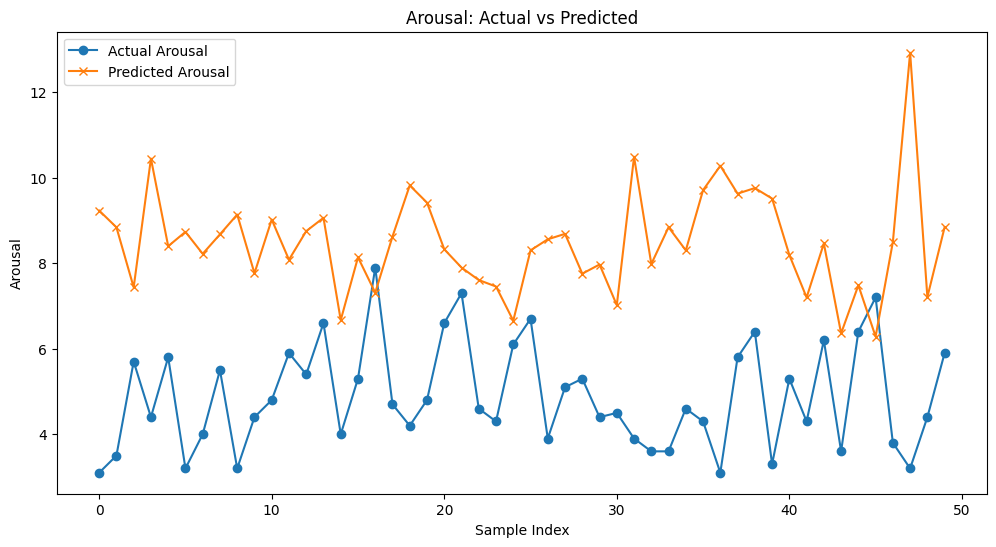

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted valence
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50, 0], label='Actual Valence', marker='o')
plt.plot(y_pred[:50, 0], label='Predicted Valence', marker='x')
plt.title("Valence: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Valence")
plt.legend()
plt.show()

# Plot actual vs predicted arousal
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50, 1], label='Actual Arousal', marker='o')
plt.plot(y_pred[:50, 1], label='Predicted Arousal', marker='x')
plt.title("Arousal: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Arousal")
plt.legend()
plt.show()
